**Question 1: Imagine you have a dataset where you have different Instagram features like `username`, `Caption`, `Hashtag`, `Followers`, `Time_Since_posted`, and `likes`. Your task is to predict `likes` and `Time_Since_posted`, and the rest of the features are your input features. Build a model.**

**[Data](https://www.kaggle.com/datasets/rxsraghavagrawal/instagram-reach)**

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    FunctionTransformer,
    PowerTransformer,
    StandardScaler,
)
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor
)
from sklearn.svm import SVR

from sklearn.compose import TransformedTargetRegressor

set_config(transform_output="pandas")

In [2]:
# Loading the data
df = pd.read_csv("Question_01_instagram_reach.csv")
df.head()

,Unnamed: 0,S.No,USERNAME,Caption,Followers,Hashtags,Time since posted,Likes
0,0,1,mikequindazzi,Who are #DataScientist and what do they do? >>...,1600,#MachineLearning #AI #DataAnalytics #DataScien...,11 hours,139
1,1,2,drgorillapaints,We all know where it’s going. We just have to ...,880,#deck .#mac #macintosh#sayhello #apple #steve...,2 hours,23
2,2,3,aitrading_official,Alexander Barinov: 4 years as CFO in multinati...,255,#whoiswho #aitrading #ai #aitradingteam#instat...,2 hours,25
3,3,4,opensourcedworkplace,sfad,340,#iot #cre#workplace #CDO #bigdata #technology#...,3 hours,49
4,4,5,crea.vision,Ever missed a call while your phone was chargi...,304,#instamachinelearning #instabigdata#instamarke...,3 hours,30


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         100 non-null    int64 
 1   S.No               100 non-null    int64 
 2   USERNAME           100 non-null    object
 3   Caption            94 non-null     object
 4   Followers          100 non-null    int64 
 5   Hashtags           100 non-null    object
 6   Time since posted  100 non-null    object
 7   Likes              100 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 6.4+ KB


In [4]:
for column in df.columns:
    print(f"'{column}' has {df[column].nunique()} unique values")

'Unnamed: 0' has 27 unique values
'S.No' has 30 unique values
'USERNAME' has 95 unique values
'Caption' has 94 unique values
'Followers' has 94 unique values
'Hashtags' has 98 unique values
'Time since posted' has 11 unique values
'Likes' has 55 unique values


The features `Unnamed: 0` and `S.No` cannot be used for prediction. Hence, we drop them. Further, features `USERNAME`, `Caption`, `Hashtags` have categorical with cardinality which is almost the same as the length of the data, and hence they have almost no predictive power. Hence, we drop these as well.

In [5]:
df.drop(["Unnamed: 0", "S.No", "USERNAME", "Caption", "Hashtags"], axis=1, inplace=True)
df.head()

,Followers,Time since posted,Likes
0,1600,11 hours,139
1,880,2 hours,23
2,255,2 hours,25
3,340,3 hours,49
4,304,3 hours,30


I will extract the numerical component of the feature `Time since posted` in a new column and delete the feature.

In [6]:
df["Time since posted (num)"] = df["Time since posted"].str.extract("(\d+)")
df["Time since posted (num)"] = df["Time since posted (num)"].astype(int)
df.drop(["Time since posted"], axis=1, inplace=True)
df.head()

,Followers,Likes,Time since posted (num)
0,1600,139,11
1,880,23,2
2,255,25,2
3,340,49,3
4,304,30,3


In [7]:
num_features = [feature for feature in df.columns if df[feature].dtype != "O"]
num_features

['Followers', 'Likes', 'Time since posted (num)']

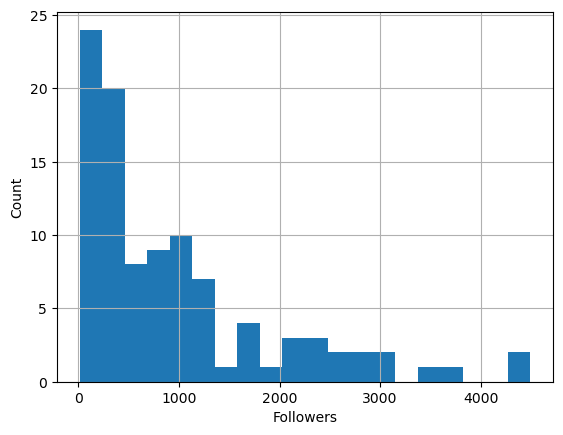

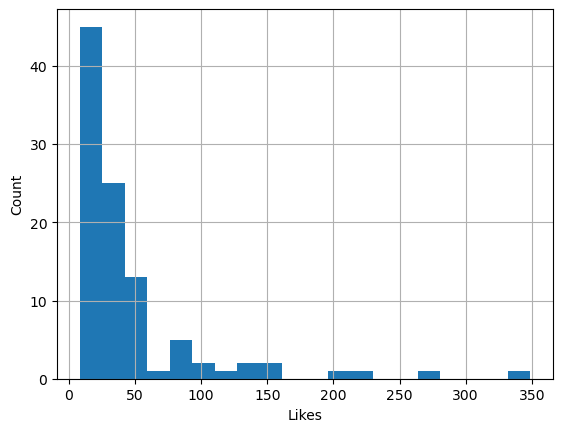

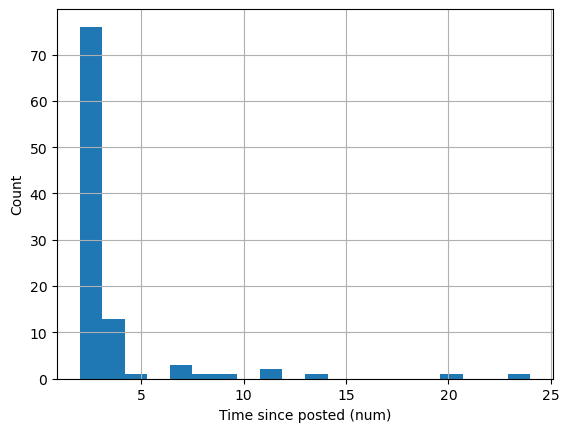

In [8]:
for feature in num_features:
    df[feature].hist(bins=20)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

In [9]:
for feature in num_features:
    print(f"{0 in df[feature].unique()}")

False
False
False


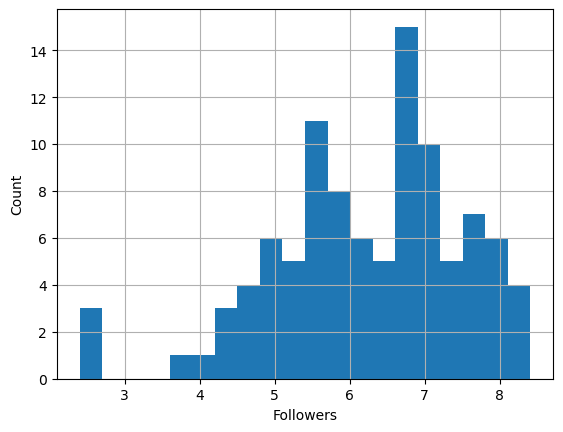

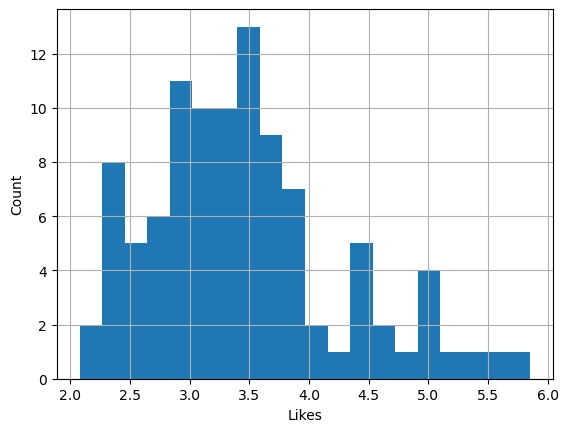

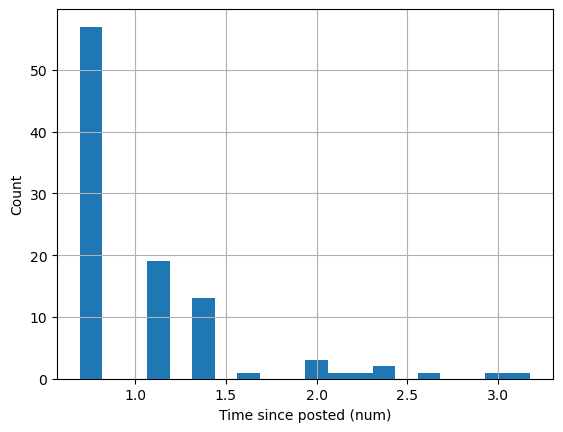

In [10]:
for feature in num_features:
    np.log(df[feature]).hist(bins=20)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

# Predicting the number of `likes`:

In [11]:
df.head()

,Followers,Likes,Time since posted (num)
0,1600,139,11
1,880,23,2
2,255,25,2
3,340,49,3
4,304,30,3


## Log Transform

In [12]:
df = np.log(df)
df.head()

,Followers,Likes,Time since posted (num)
0,7.377759,4.934474,2.397895
1,6.779922,3.135494,0.693147
2,5.541264,3.218876,0.693147
3,5.828946,3.891820,1.098612
4,5.717028,3.401197,1.098612


In [13]:
df2 = df.copy()

In [14]:
X = df[["Followers", "Time since posted (num)"]]
y = df[["Likes"]]

In [15]:
X.head()

,Followers,Time since posted (num)
0,7.377759,2.397895
1,6.779922,0.693147
2,5.541264,0.693147
3,5.828946,1.098612
4,5.717028,1.098612


In [16]:
y.head()

,Likes
0,4.934474
1,3.135494
2,3.218876
3,3.891820
4,3.401197


## Train-test split:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

In [18]:
Followers_mu = np.mean(X_train["Followers"])
Followers_std = np.std(X_train["Followers"])

Time_mu = np.mean(X_train["Time since posted (num)"])
Time_std = np.mean(X_train["Time since posted (num)"])

Likes_mu = np.mean(y_train["Likes"])
Likes_std = np.std(y_train["Likes"])

In [19]:
X_train.head()

,Followers,Time since posted (num)
60,4.976734,0.693147
80,4.941642,0.693147
90,6.760415,0.693147
68,5.916202,0.693147
51,7.730614,1.386294


In [20]:
y_train.head()

,Likes
60,2.772589
80,3.332205
90,3.465736
68,2.944439
51,5.056246


## Standard Scaling:

In [21]:
X_train["Followers"] = (X_train["Followers"] - Followers_mu) / Followers_std
X_train["Time since posted (num)"] = (X_train["Time since posted (num)"] - Time_mu) / Time_std

y_train["Likes"] = (y_train["Likes"] - Likes_mu) / Likes_std


X_test["Followers"] = (X_test["Followers"] - Followers_mu) / Followers_std
X_test["Time since posted (num)"] = (X_test["Time since posted (num)"] - Time_mu) / Time_std

# y_test["Likes"] = (y_test["Likes"] - Likes_mu) / Likes_std

In [22]:
X_train.head()

,Followers,Time since posted (num)
60,-1.020225,-0.326176
80,-1.047425,-0.326176
90,0.362302,-0.326176
68,-0.292045,-0.326176
51,1.114302,0.347647


In [23]:
y_train.head()

,Likes
60,-0.808164
80,-0.090658
90,0.080548
68,-0.587828
51,2.119805


## Model

In [24]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [25]:
pred = regressor.predict(X_test)

In [26]:
pred = (Likes_std * pred) + Likes_mu

In [27]:
np.exp(y_test)

,Likes
26,25.0
86,43.0
2,25.0
55,349.0
75,119.0
93,20.0
16,29.0
73,10.0
54,65.0
95,31.0


In [28]:
np.exp(pred)

array([[ 21.86798305],
       [ 35.80693772],
       [ 21.75011633],
       [157.21536198],
       [ 30.09602574],
       [ 20.69515054],
       [ 34.63723017],
       [ 29.75404288],
       [ 68.59733924],
       [ 32.01255537],
       [ 29.31838723],
       [ 19.22641391],
       [ 21.64058897],
       [ 72.905772  ],
       [ 43.46000907],
       [ 25.66408491],
       [ 26.50295603],
       [ 20.47707572],
       [ 24.58563368],
       [ 22.44641216],
       [ 26.0228853 ],
       [ 24.39426707],
       [ 29.46154774],
       [ 23.02937006],
       [ 19.60994384],
       [ 41.24066616],
       [ 28.35642169],
       [ 32.86942584],
       [ 25.73747192],
       [ 20.72748346]])

# Predicting `Time since posted`:

In [29]:
df2.head()

,Followers,Likes,Time since posted (num)
0,7.377759,4.934474,2.397895
1,6.779922,3.135494,0.693147
2,5.541264,3.218876,0.693147
3,5.828946,3.891820,1.098612
4,5.717028,3.401197,1.098612


In [30]:
X = df[["Followers", "Likes"]]
y = df[["Time since posted (num)"]]

X.head()

,Followers,Likes
0,7.377759,4.934474
1,6.779922,3.135494
2,5.541264,3.218876
3,5.828946,3.891820
4,5.717028,3.401197


In [31]:
y.head()

,Time since posted (num)
0,2.397895
1,0.693147
2,0.693147
3,1.098612
4,1.098612


## Train-test split:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

In [33]:
X_train.head()

,Followers,Likes
60,4.976734,2.772589
80,4.941642,3.332205
90,6.760415,3.465736
68,5.916202,2.944439
51,7.730614,5.056246


In [34]:
y_train.head()

,Time since posted (num)
60,0.693147
80,0.693147
90,0.693147
68,0.693147
51,1.386294


## Standard scaling:

In [35]:
Followers_mu = np.mean(X_train["Followers"])
Followers_std = np.std(X_train["Followers"])

Likes_mu = np.mean(X_train["Likes"])
Likes_std = np.std(X_train["Likes"])

Time_mu = np.mean(y_train["Time since posted (num)"])
Time_std = np.mean(y_train["Time since posted (num)"])

In [36]:
X_train["Followers"] = (X_train["Followers"] - Followers_mu) / Followers_std
X_train["Likes"] = (X_train["Likes"] - Likes_mu) / Likes_std

y_train["Time since posted (num)"] = (y_train["Time since posted (num)"] - Time_mu) / Time_std


X_test["Followers"] = (X_test["Followers"] - Followers_mu) / Followers_std
X_test["Likes"] = (X_test["Likes"] - Likes_mu) / Likes_std

# y_test["Likes"] = (y_test["Likes"] - Likes_mu) / Likes_std

In [37]:
X_train.head()

,Followers,Likes
60,-1.020225,-0.808164
80,-1.047425,-0.090658
90,0.362302,0.080548
68,-0.292045,-0.587828
51,1.114302,2.119805


In [38]:
y_train.head()

,Time since posted (num)
60,-0.326176
80,-0.326176
90,-0.326176
68,-0.326176
51,0.347647


## Model:

In [39]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [40]:
pred = regressor.predict(X_test)

In [41]:
pred = (Time_std * pred) + Time_mu

In [42]:
np.exp(y_test)

,Time since posted (num)
26,2.0
86,4.0
2,2.0
55,24.0
75,2.0
93,2.0
16,4.0
73,2.0
54,7.0
95,3.0


In [43]:
np.exp(pred)

array([[2.63042642],
       [3.10462714],
       [2.62954751],
       [5.94213314],
       [4.28884427],
       [2.45136325],
       [2.75220899],
       [2.03538379],
       [3.57826407],
       [2.82673982],
       [2.57331581],
       [2.09279667],
       [2.10815991],
       [3.94099367],
       [3.87010303],
       [3.90471593],
       [2.48914586],
       [1.98889493],
       [2.79884902],
       [2.46580471],
       [3.78620638],
       [2.71026415],
       [3.22730299],
       [3.25032769],
       [2.78733175],
       [3.16822177],
       [2.90988875],
       [4.13220348],
       [2.83459315],
       [2.0482543 ]])